## DDPG Portfolio Management

In [1]:
import numpy as np
from allocation_env import AssetAllocationEnv
from ddpg_agent import DDPGAgent
import pickle
import pandas as pd
import tensorflow as tf
from rl_interface import RLInterface
tf.get_logger().setLevel('ERROR')
from market_data import MarketData
from keras.layers import Dense, Flatten
from keras.activations import relu
from keras.initializers import glorot_uniform
from transformer_encoder import EncoderLayer

2024-03-10 20:41:55.585650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 20:41:55.585678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 20:41:55.586655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 20:41:55.591764: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 20:41:56.127887: W tensorflow/compiler/tf2

##### Number of stocks in the portfolio, beginning date and ending date

In [2]:
num_stocks = 10
start_date = '2013-01-03'
end_date = '2024-02-01'

##### Import locally stored data for stock prices, macro variables, and risk-free rate

In [3]:
with open('data/top_10_stocks_2013-01-03_to_2024-02-01_as_of_02-10-2024.pkl', 'rb') as file:
    price_dict = pickle.load(file)  # dictionary of dataframes of the form {ticker: dataframe of candles}
price_dict['AAPL']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.536327,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.075716,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,15.981145,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.024164,458707200
2013-01-09,18.660713,18.750357,18.428213,18.467857,15.773727,407604400
...,...,...,...,...,...,...
2024-01-25,195.220001,196.270004,193.110001,194.169998,193.922546,54822100
2024-01-26,194.270004,194.759995,191.940002,192.419998,192.174774,44594000
2024-01-29,192.009995,192.199997,189.580002,191.729996,191.485657,47145600


In [4]:
with open('data/macro_factors_2013-01-03_to_2024-02-01.pkl', 'rb') as file:
    macro = pickle.load(file)
macro

,5 Yr BE Inf,5 Yr Fwd Inf Exp,Fed Funds Rate,10-2 Yr Tr Yld,VIX
Date,,,,,
2013-01-03,2.11,2.81,0.17,1.65,14.56
2013-01-04,2.13,2.83,0.16,1.66,13.83
2013-01-07,2.16,2.88,0.16,1.65,13.79
2013-01-08,2.15,2.83,0.15,1.64,13.62
2013-01-09,2.18,2.86,0.14,1.64,13.81
...,...,...,...,...,...
2024-01-25,2.24,2.34,5.33,-0.14,13.45
2024-01-26,2.26,2.34,5.33,-0.19,13.26
2024-01-29,2.26,2.34,5.33,-0.21,13.60


In [5]:
with open('data/3_mo_treasury_2013-01-03_to_2024-02-01.pkl', 'rb') as file:
    rf = pickle.load(file)
rf

Date
2013-01-03    0.0008
2013-01-04    0.0007
2013-01-07    0.0007
2013-01-08    0.0007
2013-01-09    0.0006
               ...  
2024-01-25    0.0544
2024-01-26    0.0544
2024-01-29    0.0542
2024-01-30    0.0542
2024-01-31    0.0542
Name: 3 Mo Tr Yld, Length: 2788, dtype: float64

#### Fetch list of S&P ticker and weights (Use of of the Options Below: Cap or Equal Weighting)

##### *Cap Weighting*

In [6]:
# with open('data/sp500_weights_as_of_02-10-2024.pkl', 'rb') as file:
#     sp_df = pickle.load(file)
# display(sp_df)
# sp_weights = sp_df['Weight'].iloc[:num_stocks]/sum(sp_df['Weight'].iloc[:num_stocks])
# sp_weights = sp_weights.to_numpy()
# sp_weights_array = np.repeat(sp_weights[np.newaxis, :], len(price_dict[list(price_dict.keys())[0]]), axis=0)

##### *Equal Weighting*

In [7]:
sp_weights = np.ones(num_stocks)/num_stocks
sp_weights_array = np.repeat(sp_weights[np.newaxis, :], len(price_dict[list(price_dict.keys())[0]]), axis=0)

##### Initalize MarketData object for input into RL environment

In [8]:
market_data = MarketData(price_dict, sp_weights_array, rf, macro, scaler='minmax', flatten=True, train_prop=0.7)

##### Environment Instantiation

In [9]:
# Create 2 environments: one for training and one for testing which access mutually exclusive (and consecutive) time series from market_data
train_env = AssetAllocationEnv(market_data=market_data, lookback=30, holding_period=5, 
                               window_size=150, rebalance=True, reward_type='alpha', train=True)
test_env = AssetAllocationEnv(market_data=market_data, lookback=30, holding_period=5, 
                              window_size=200, rebalance=True, reward_type='alpha', train=False)

lr_actor = 0.005
lr_critic = 0.005
tau = 0.005
gamma = 0.99
sigma = 0.75

buffer_capacity = 100000
batch_size = 256

dir = 'models/encoder_model'
chkpt_dir = dir + '/network_weights'
history_dir = dir + '/history'

##### Neural Network Architectures

In [10]:
# Middle layers of the network (Input and output layers are defined in separate module for Actor and Critic models) 
actor_layers = [
    EncoderLayer(input_shape=train_env.obs_shape, head_size=5, num_heads=3, gru_units=64,
    dense_units=512, dropout=0.1), 
    EncoderLayer(input_shape=train_env.obs_shape, head_size=5, num_heads=3, gru_units=64,
    dense_units=512, dropout=0.1),
    Flatten(),
    Dense(512, activation=relu, kernel_initializer=glorot_uniform()),  
    Dense(512, activation=relu, kernel_initializer=glorot_uniform())  
]

critic_layers = [
    Dense(512, activation=relu, kernel_initializer=glorot_uniform()), 
    Dense(512, activation=relu, kernel_initializer=glorot_uniform()) 
]

2024-03-10 20:41:57.441148: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 20:41:57.441380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 20:41:57.473596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

##### GPU Distribution Strategy *(use if  multiple GPUs are available)*

In [11]:
strategy = tf.distribute.MirroredStrategy()

##### Agent Instantiation

In [12]:
agent = DDPGAgent(env=train_env, actor_layers=actor_layers, critic_layers=critic_layers, lr_actor=lr_actor, 
                  lr_critic=lr_critic, chkpt_dir=chkpt_dir, tau=tau, gamma=gamma, sigma=sigma, 
                  buffer_capacity=buffer_capacity, batch_size=batch_size, strategy=strategy)

2024-03-10 20:41:58.307957: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [13]:
print(agent.actor.summary())

Model: "actor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 65)]          0         
                                                                 
 encoder_layer (EncoderLaye  multiple                  29422     
 r)                                                              
                                                                 
 encoder_layer_1 (EncoderLa  multiple                  29165     
 yer)                                                            
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense (Dense)               multiple                  983552    
                                                                 
 dense_1 (Dense)             multiple                  262656

In [14]:
print(agent.critic.summary())

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  1004032   
                                                                 
 dense_3 (Dense)             multiple                  262656    
                                                                 
 dense_5 (Dense)             multiple                  513       
                                                                 
Total params: 1267201 (4.83 MB)
Trainable params: 1267201 (4.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [15]:
interface = RLInterface(train_env=train_env, test_env=test_env, agent=agent)

## Training

##### Uncomment below line to load model parameters from disk

In [16]:
# interface.load_models()

##### Training Loop

In [17]:
train_history = interface.train_agent(num_episodes=150, verbose=1, seed=None, advanced_stats=True) # If NaN appear in scores, data is not cleaned properly

Training progress:   0%|          | 0/150 [00:00<?, ?it/s]

Episode: 1/150, Score: 0.0021, 10 epi avg.: 0.0021, All-time avg.: 0.0021
Episode: 2/150, Score: -0.0048, 10 epi avg.: -0.0014, All-time avg.: -0.0014
Episode: 3/150, Score: -0.0010, 10 epi avg.: -0.0013, All-time avg.: -0.0013
Episode: 4/150, Score: 0.0014, 10 epi avg.: -0.0006, All-time avg.: -0.0006
Episode: 5/150, Score: 0.0034, 10 epi avg.: 0.0002, All-time avg.: 0.0002
Episode: 6/150, Score: -0.0088, 10 epi avg.: -0.0013, All-time avg.: -0.0013
Episode: 7/150, Score: -0.0039, 10 epi avg.: -0.0017, All-time avg.: -0.0017
Episode: 8/150, Score: 0.0001, 10 epi avg.: -0.0014, All-time avg.: -0.0014
Episode: 9/150, Score: -0.0029, 10 epi avg.: -0.0016, All-time avg.: -0.0016
Episode: 10/150, Score: -0.0063, 10 epi avg.: -0.0021, All-time avg.: -0.0021


2024-03-10 20:42:29.605395: I external/local_xla/xla/service/service.cc:168] XLA service 0x79ae5484eaa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 20:42:29.605415: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-03-10 20:42:29.605421: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-03-10 20:42:29.609244: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-10 20:42:29.622180: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710117749.673872   22719 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 11/150, Score: 0.0027, 10 epi avg.: -0.0020, All-time avg.: -0.0016
Episode: 12/150, Score: -0.0077, 10 epi avg.: -0.0023, All-time avg.: -0.0021
Episode: 13/150, Score: 0.0039, 10 epi avg.: -0.0018, All-time avg.: -0.0017
Episode: 14/150, Score: -0.0171, 10 epi avg.: -0.0037, All-time avg.: -0.0028
Episode: 15/150, Score: -0.0018, 10 epi avg.: -0.0042, All-time avg.: -0.0027
Episode: 16/150, Score: 0.0041, 10 epi avg.: -0.0029, All-time avg.: -0.0023
Episode: 17/150, Score: -0.0057, 10 epi avg.: -0.0031, All-time avg.: -0.0025
Episode: 18/150, Score: -0.0075, 10 epi avg.: -0.0038, All-time avg.: -0.0028
Episode: 19/150, Score: 0.0050, 10 epi avg.: -0.0030, All-time avg.: -0.0024
Episode: 20/150, Score: -0.0123, 10 epi avg.: -0.0036, All-time avg.: -0.0029
Episode: 21/150, Score: 0.0010, 10 epi avg.: -0.0038, All-time avg.: -0.0027
Episode: 22/150, Score: -0.0047, 10 epi avg.: -0.0035, All-time avg.: -0.0028
Episode: 23/150, Score: -0.0084, 10 epi avg.: -0.0047, All-time avg.:

##### Plot Learning

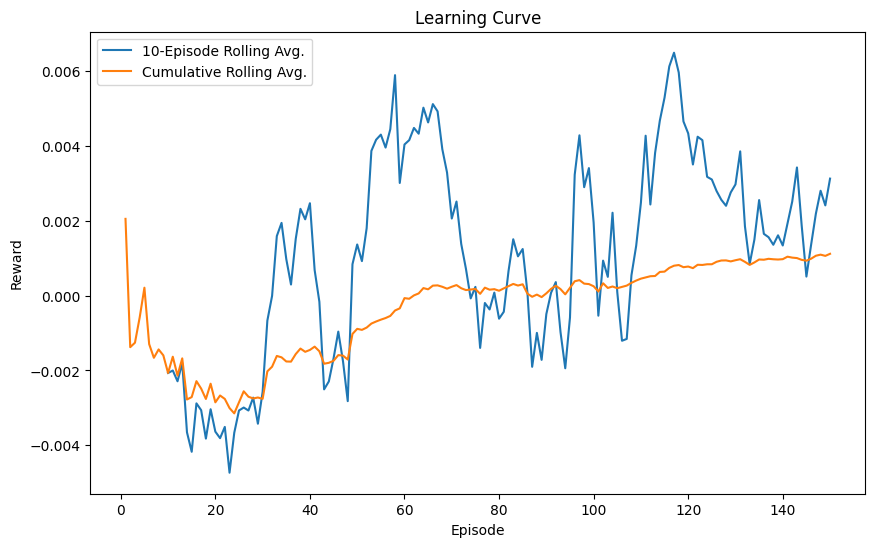

In [18]:
train_scores = train_history['avg_epi_score_history']
interface.plot_learning(engine='matplotlib', scores=train_scores, rolling_period=10)

##### Render Last Episode

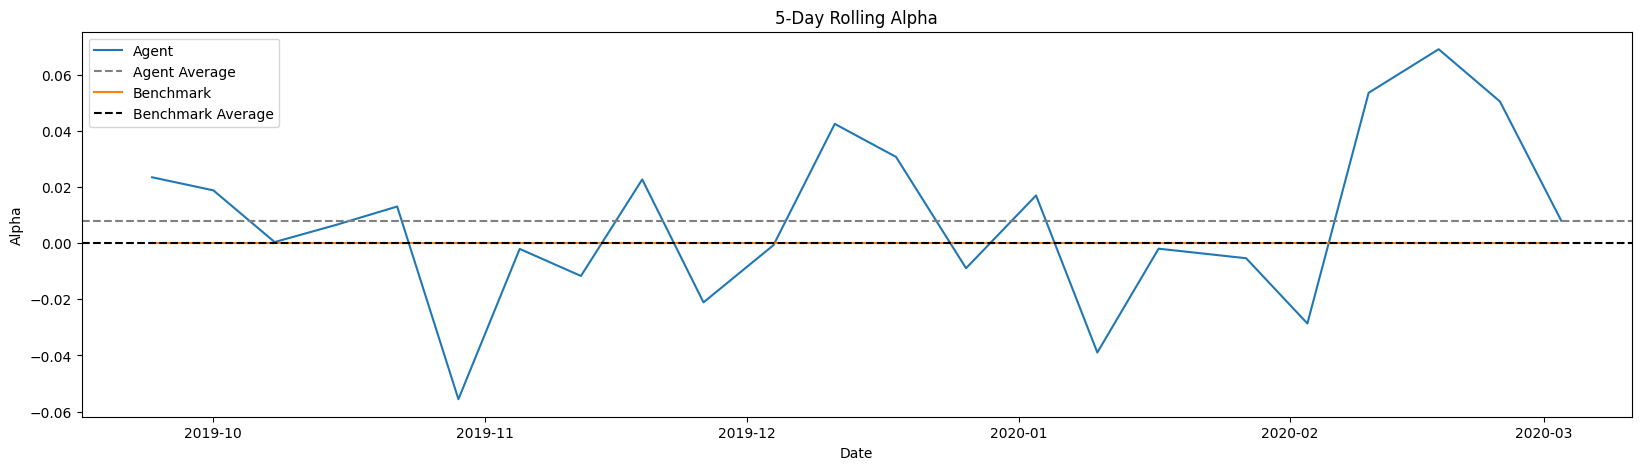

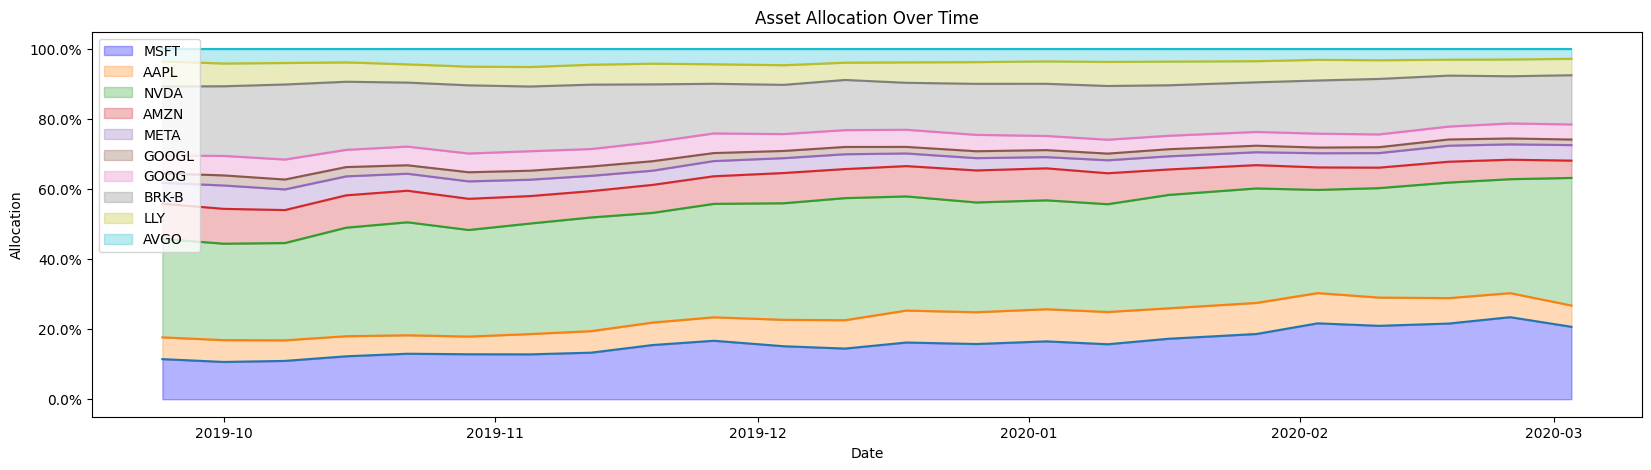

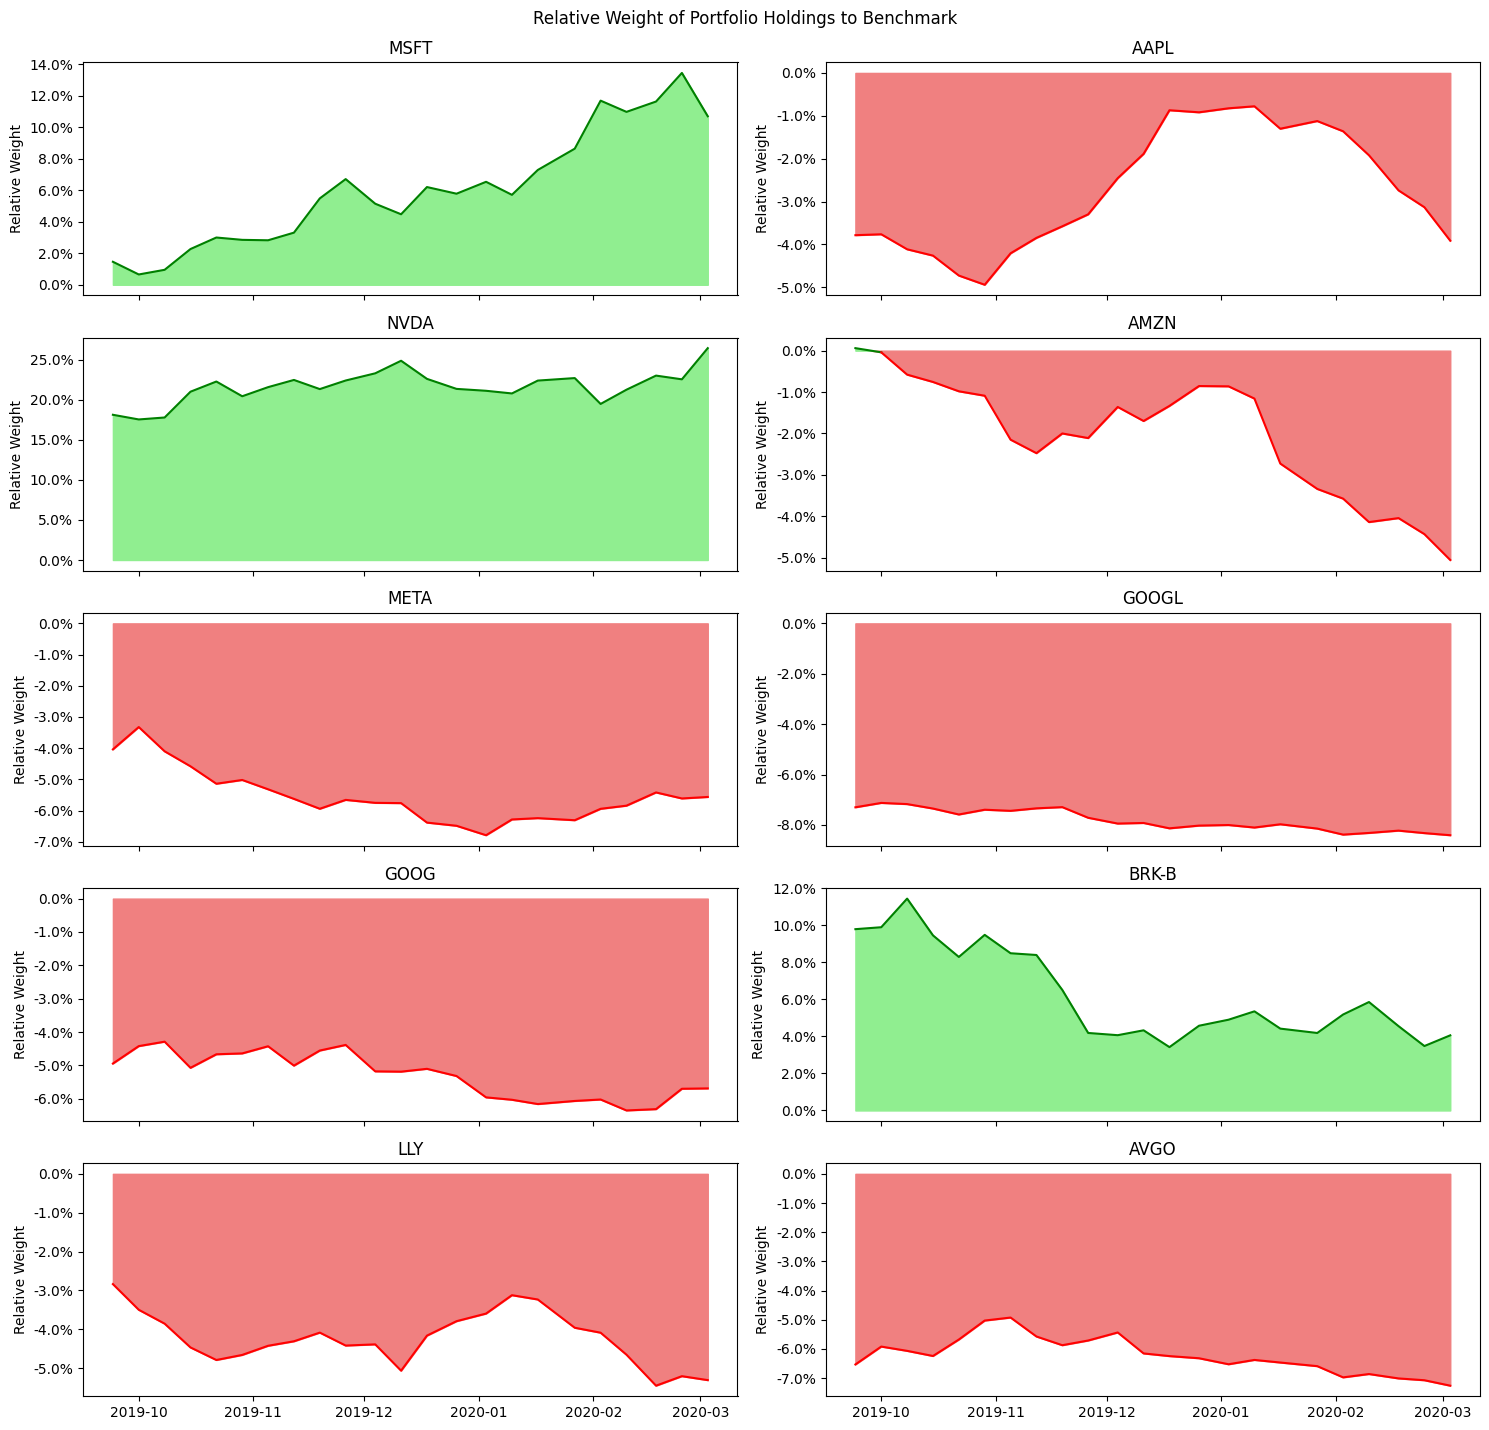

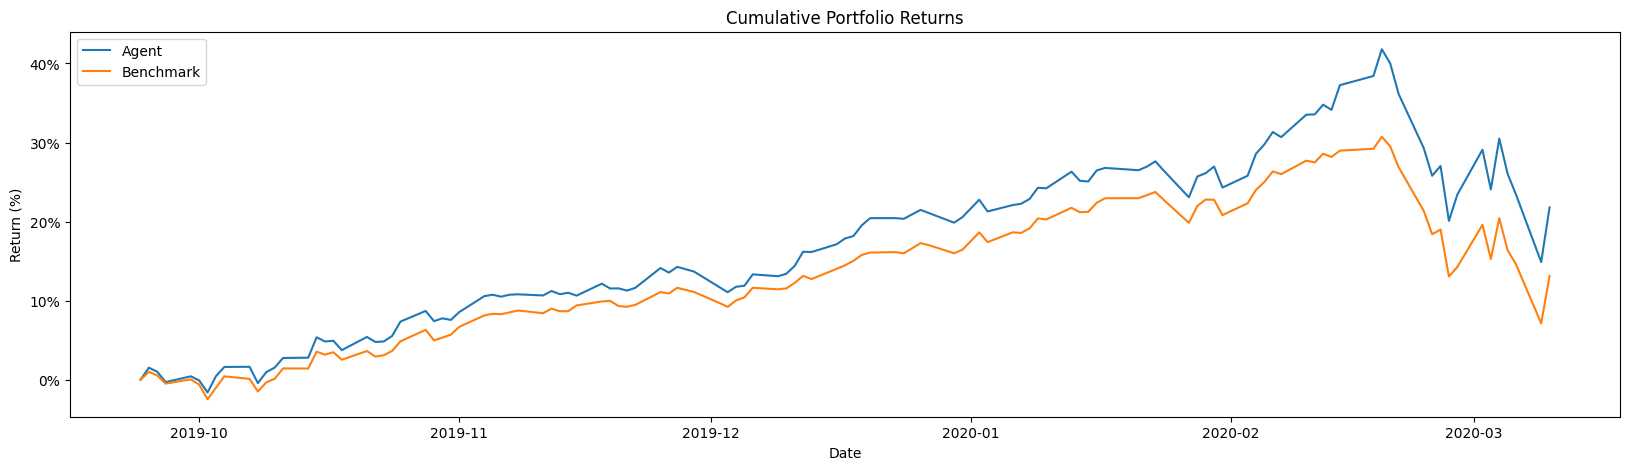

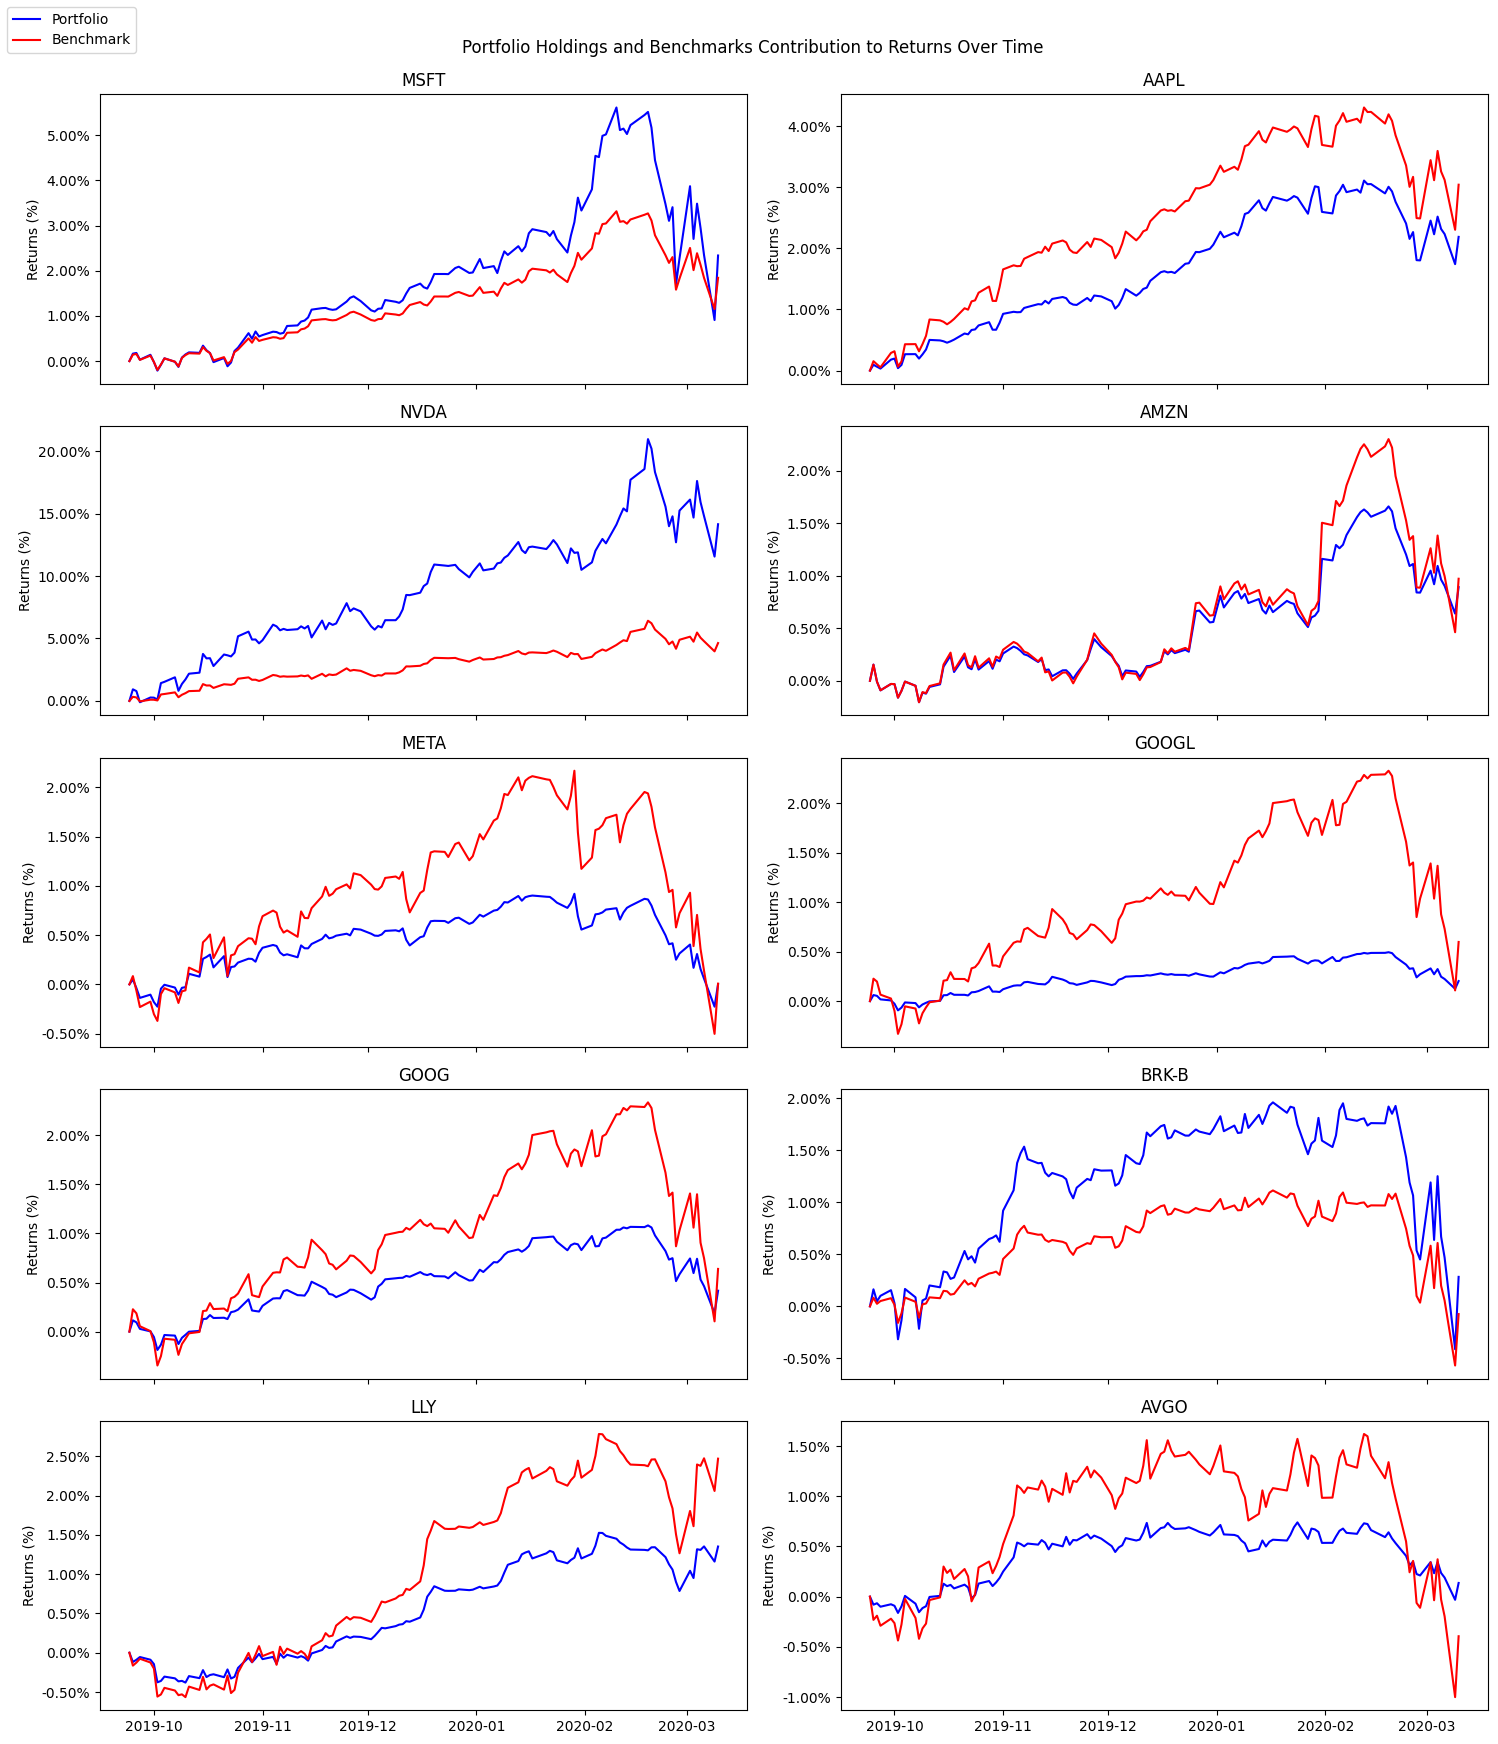

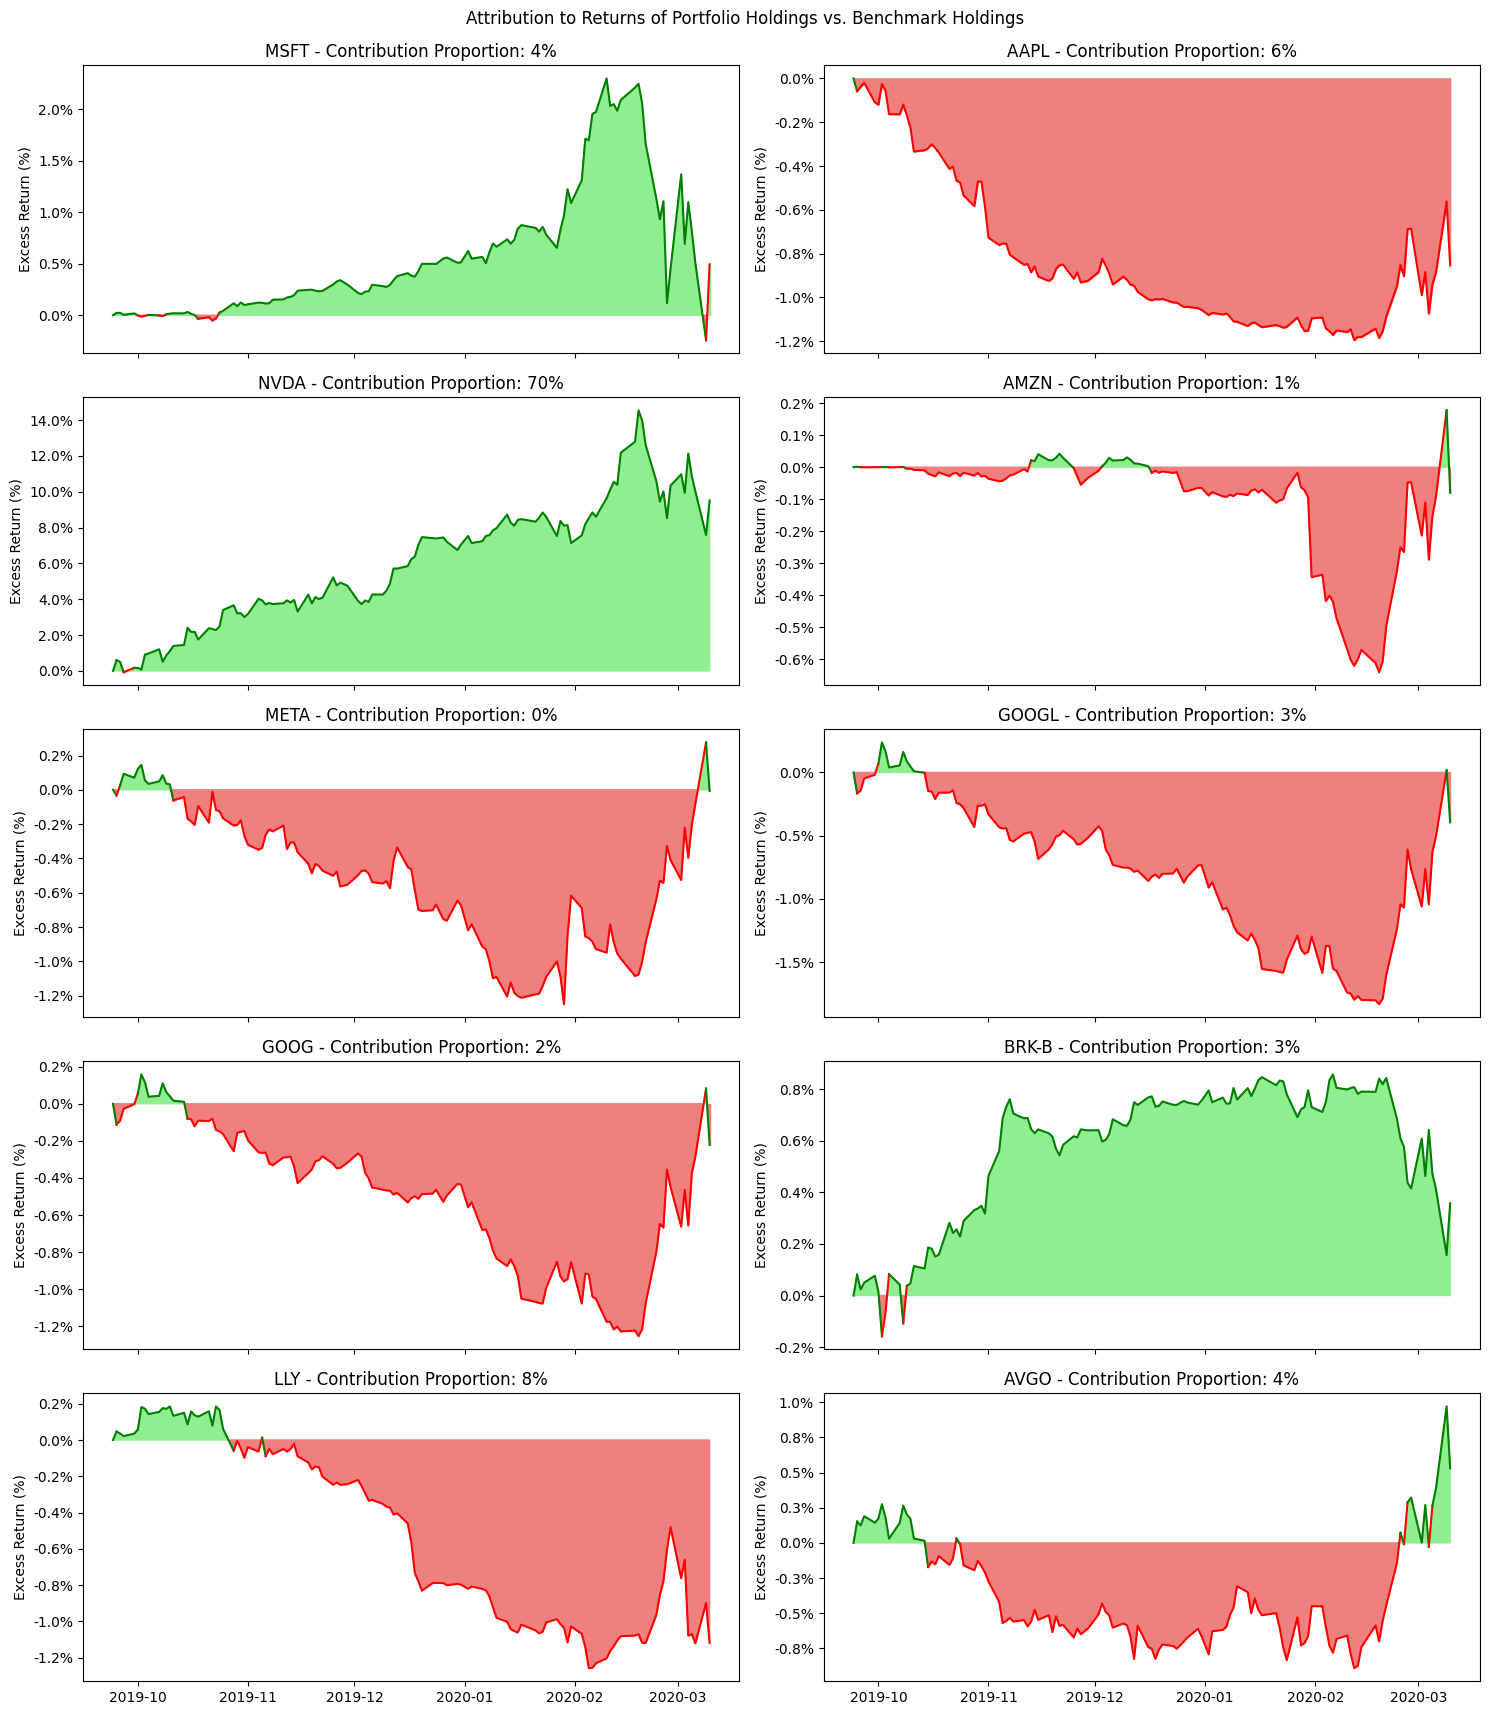

In [19]:
train_env.render(engine='matplotlib', plot_benchmark=True, plot_actions=True, plot_relative=True, plot_returns=True, plot_individual=True, plot_contribution=True)

##### Last Episode Performance

In [20]:
print('Agent Vol (Ann.): {:.3f}%'.format(np.std(train_env.portfolio_returns)*100*np.sqrt(252)))
print('Benchmark Vol (Ann.): {:.3f}%'.format(np.std(train_env.benchmark_returns)*100*np.sqrt(252)))
print('Correlation: %.3f' % np.corrcoef(np.squeeze(train_env.portfolio_returns), np.squeeze(train_env.benchmark_returns))[0,1])
beta = np.cov(np.squeeze(train_env.portfolio_returns), np.squeeze(train_env.benchmark_returns), ddof=1)[0,1] / np.var(train_env.benchmark_returns, ddof=1)
print('Beta: %.3f' % beta)
print('Excess Return: {:.3f}%'.format((np.cumprod(1+train_env.portfolio_returns)[-1] - np.cumprod(1+train_env.benchmark_returns)[-1])*100))
print('Episode Alpha (rf=0%): {:.3f}%'.format((np.cumprod(1+train_env.portfolio_returns)[-1] - beta*(np.cumprod(1+train_env.benchmark_returns)[-1]))*100))

Agent Vol (Ann.): 28.044%
Benchmark Vol (Ann.): 24.427%
Correlation: 0.975
Beta: 1.119
Excess Return: 8.667%
Episode Alpha (rf=0%): -4.826%


##### Training Sample Performance Statistics

In [21]:
interface.print_advanced_stats(train_history)

Avg. Reward: 0.001
Avg. Volatility (Agent, Ann.): 22.506%
Avg. Risk Utilization (% of benchmark): 108.777%
Avg. Beta: 1.017
Avg. Correlation: 0.938
Avg. Return (Epi.): 113.504%
Avg. Excess Return (Epi.): 0.676%
Avg. Alpha (Ann., rf=0%): -0.121%


##### Save model parameters to disk

In [22]:
interface.save_models()

..... Saving models .....
..... Models saved successfully! .....


## Testing

In [23]:
test_history = interface.test_agent(num_episodes=50, verbose=1, seed=None, advanced_stats=True)

Testing progress:   0%|          | 0/50 [00:00<?, ?it/s]

Episode: 1/50, Score: -0.0016, 10 epi avg.: -0.0016, All-time avg.: -0.0016
Episode: 2/50, Score: 0.0023, 10 epi avg.: 0.0004, All-time avg.: 0.0004
Episode: 3/50, Score: -0.0014, 10 epi avg.: -0.0002, All-time avg.: -0.0002
Episode: 4/50, Score: -0.0007, 10 epi avg.: -0.0003, All-time avg.: -0.0003
Episode: 5/50, Score: -0.0007, 10 epi avg.: -0.0004, All-time avg.: -0.0004
Episode: 6/50, Score: -0.0030, 10 epi avg.: -0.0008, All-time avg.: -0.0008
Episode: 7/50, Score: 0.0044, 10 epi avg.: -0.0001, All-time avg.: -0.0001
Episode: 8/50, Score: -0.0018, 10 epi avg.: -0.0003, All-time avg.: -0.0003
Episode: 9/50, Score: -0.0022, 10 epi avg.: -0.0005, All-time avg.: -0.0005
Episode: 10/50, Score: -0.0041, 10 epi avg.: -0.0009, All-time avg.: -0.0009
Episode: 11/50, Score: -0.0112, 10 epi avg.: -0.0018, All-time avg.: -0.0018
Episode: 12/50, Score: 0.0097, 10 epi avg.: -0.0011, All-time avg.: -0.0008
Episode: 13/50, Score: -0.0104, 10 epi avg.: -0.0020, All-time avg.: -0.0016
Episode: 14/5

##### Render Last Episode

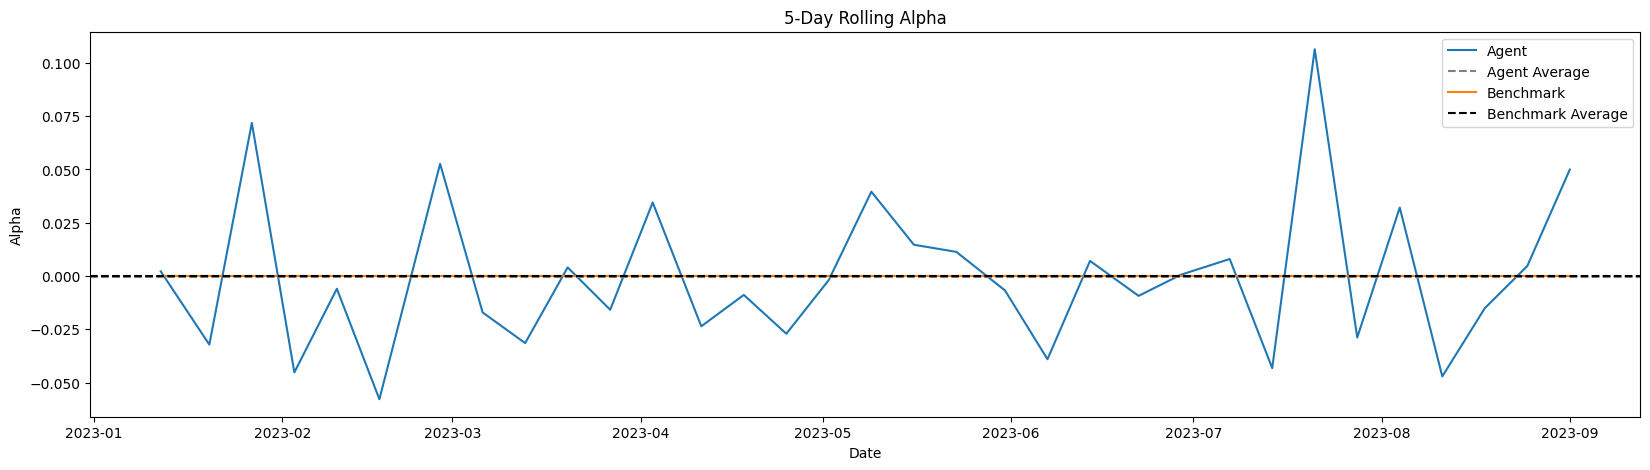

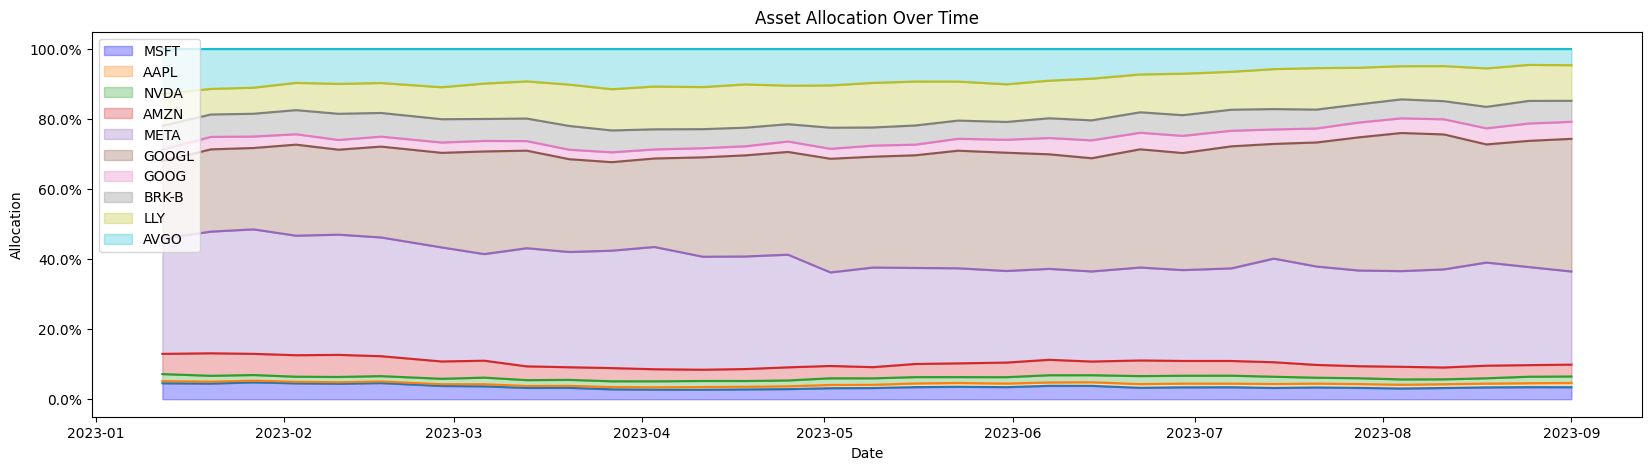

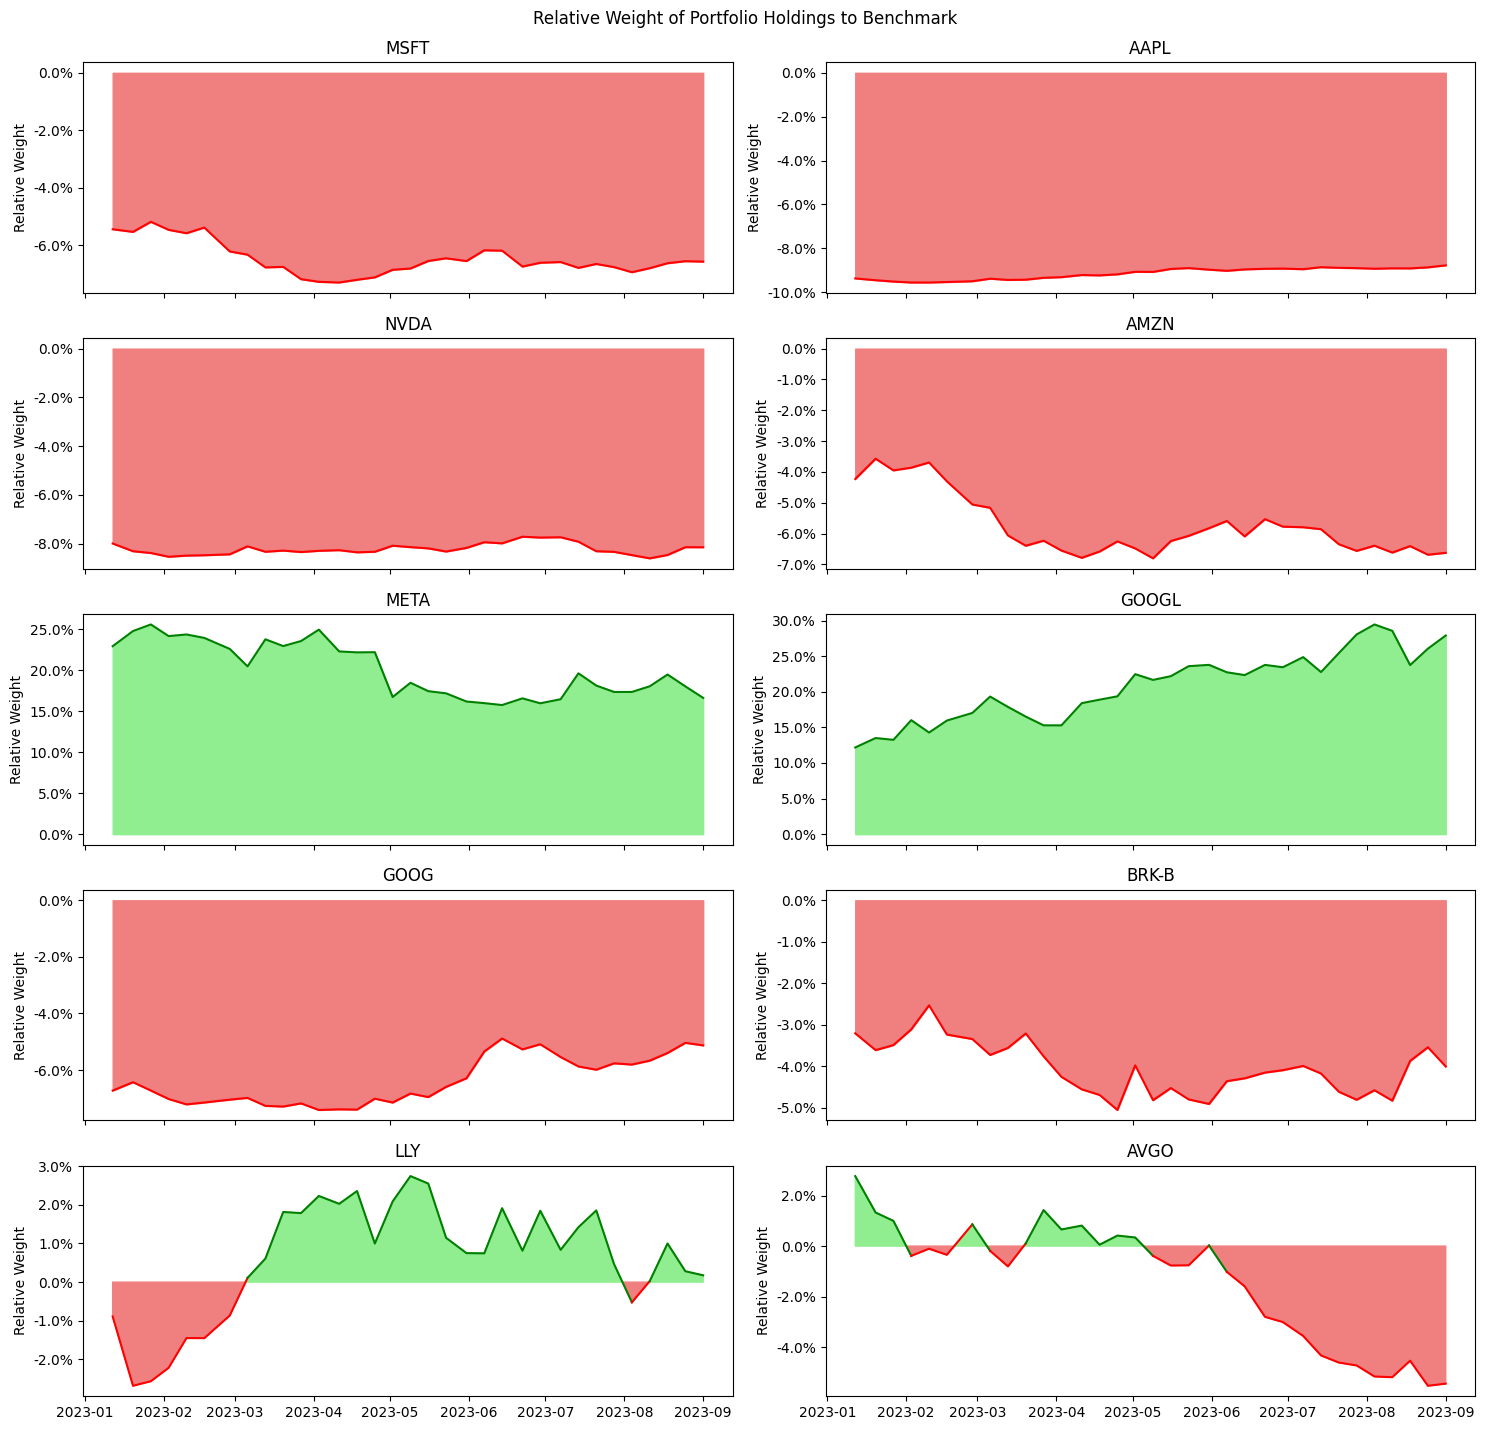

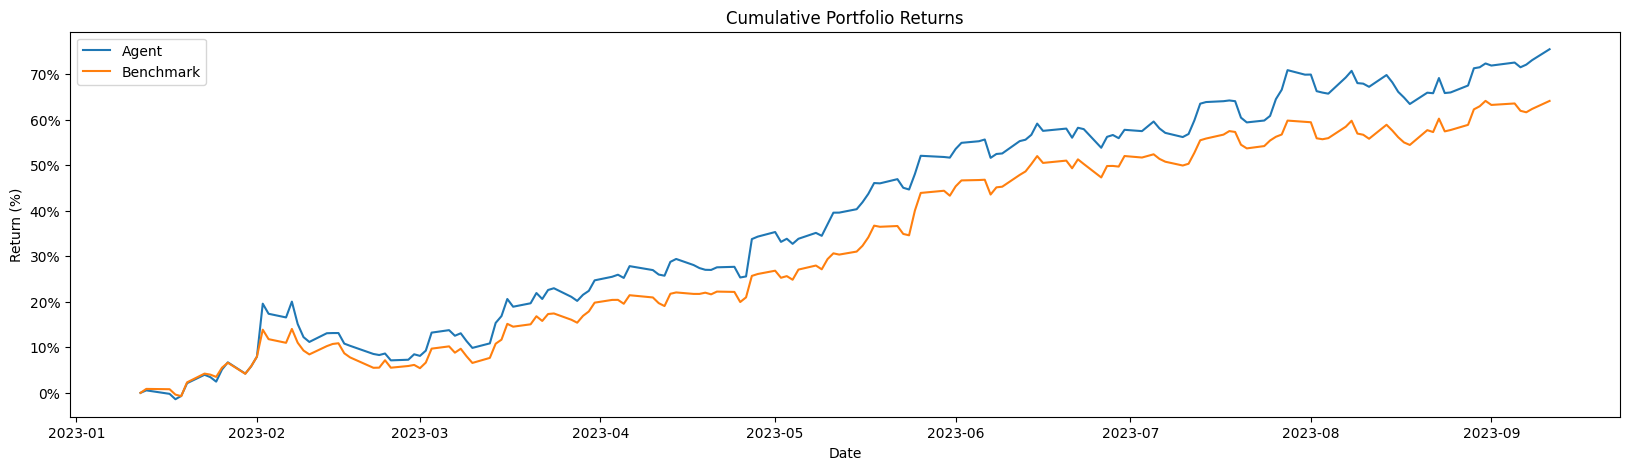

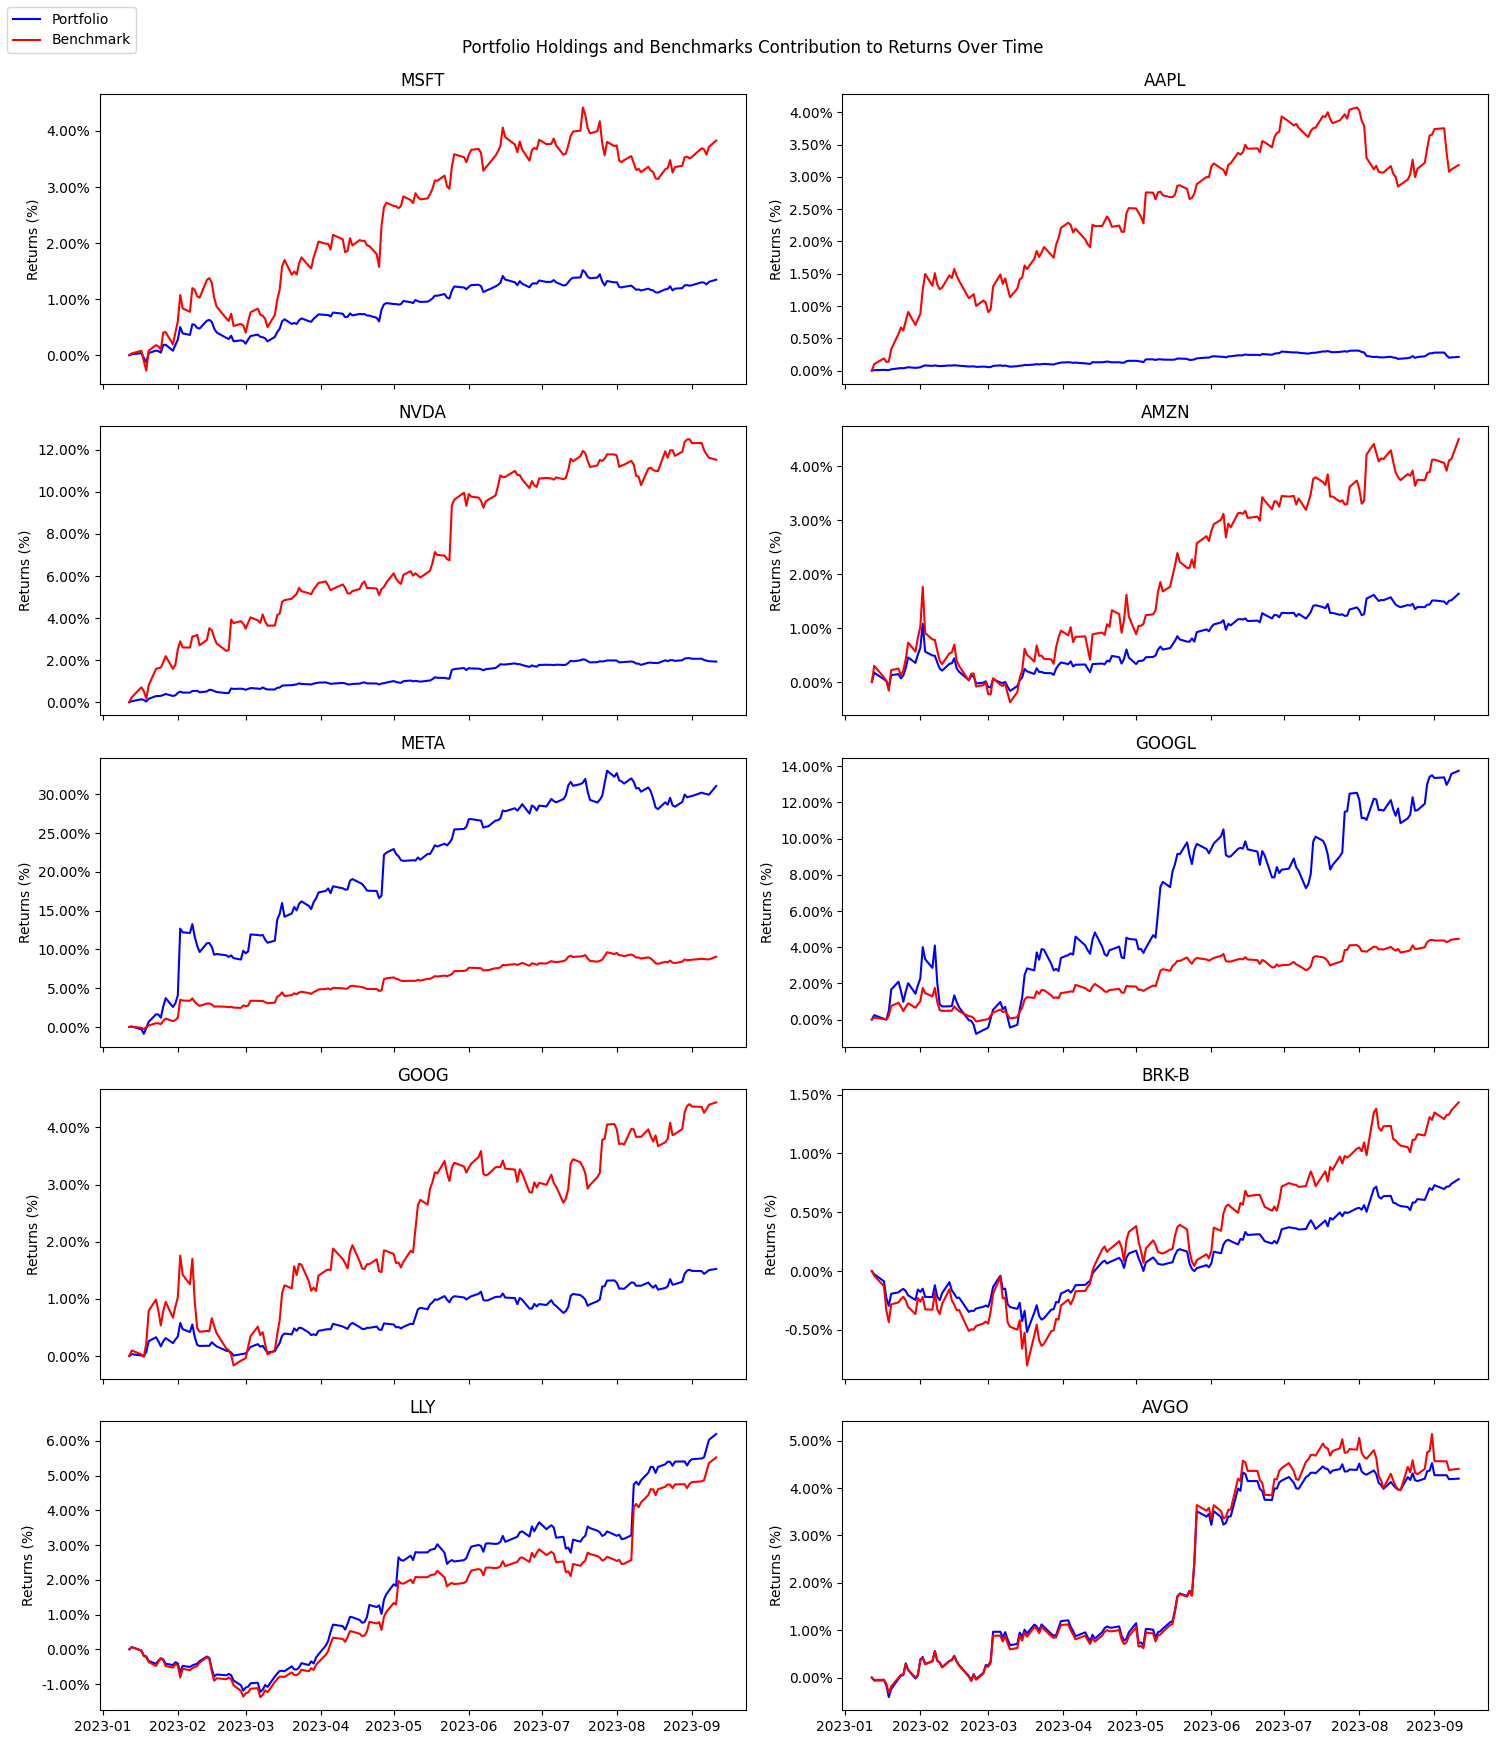

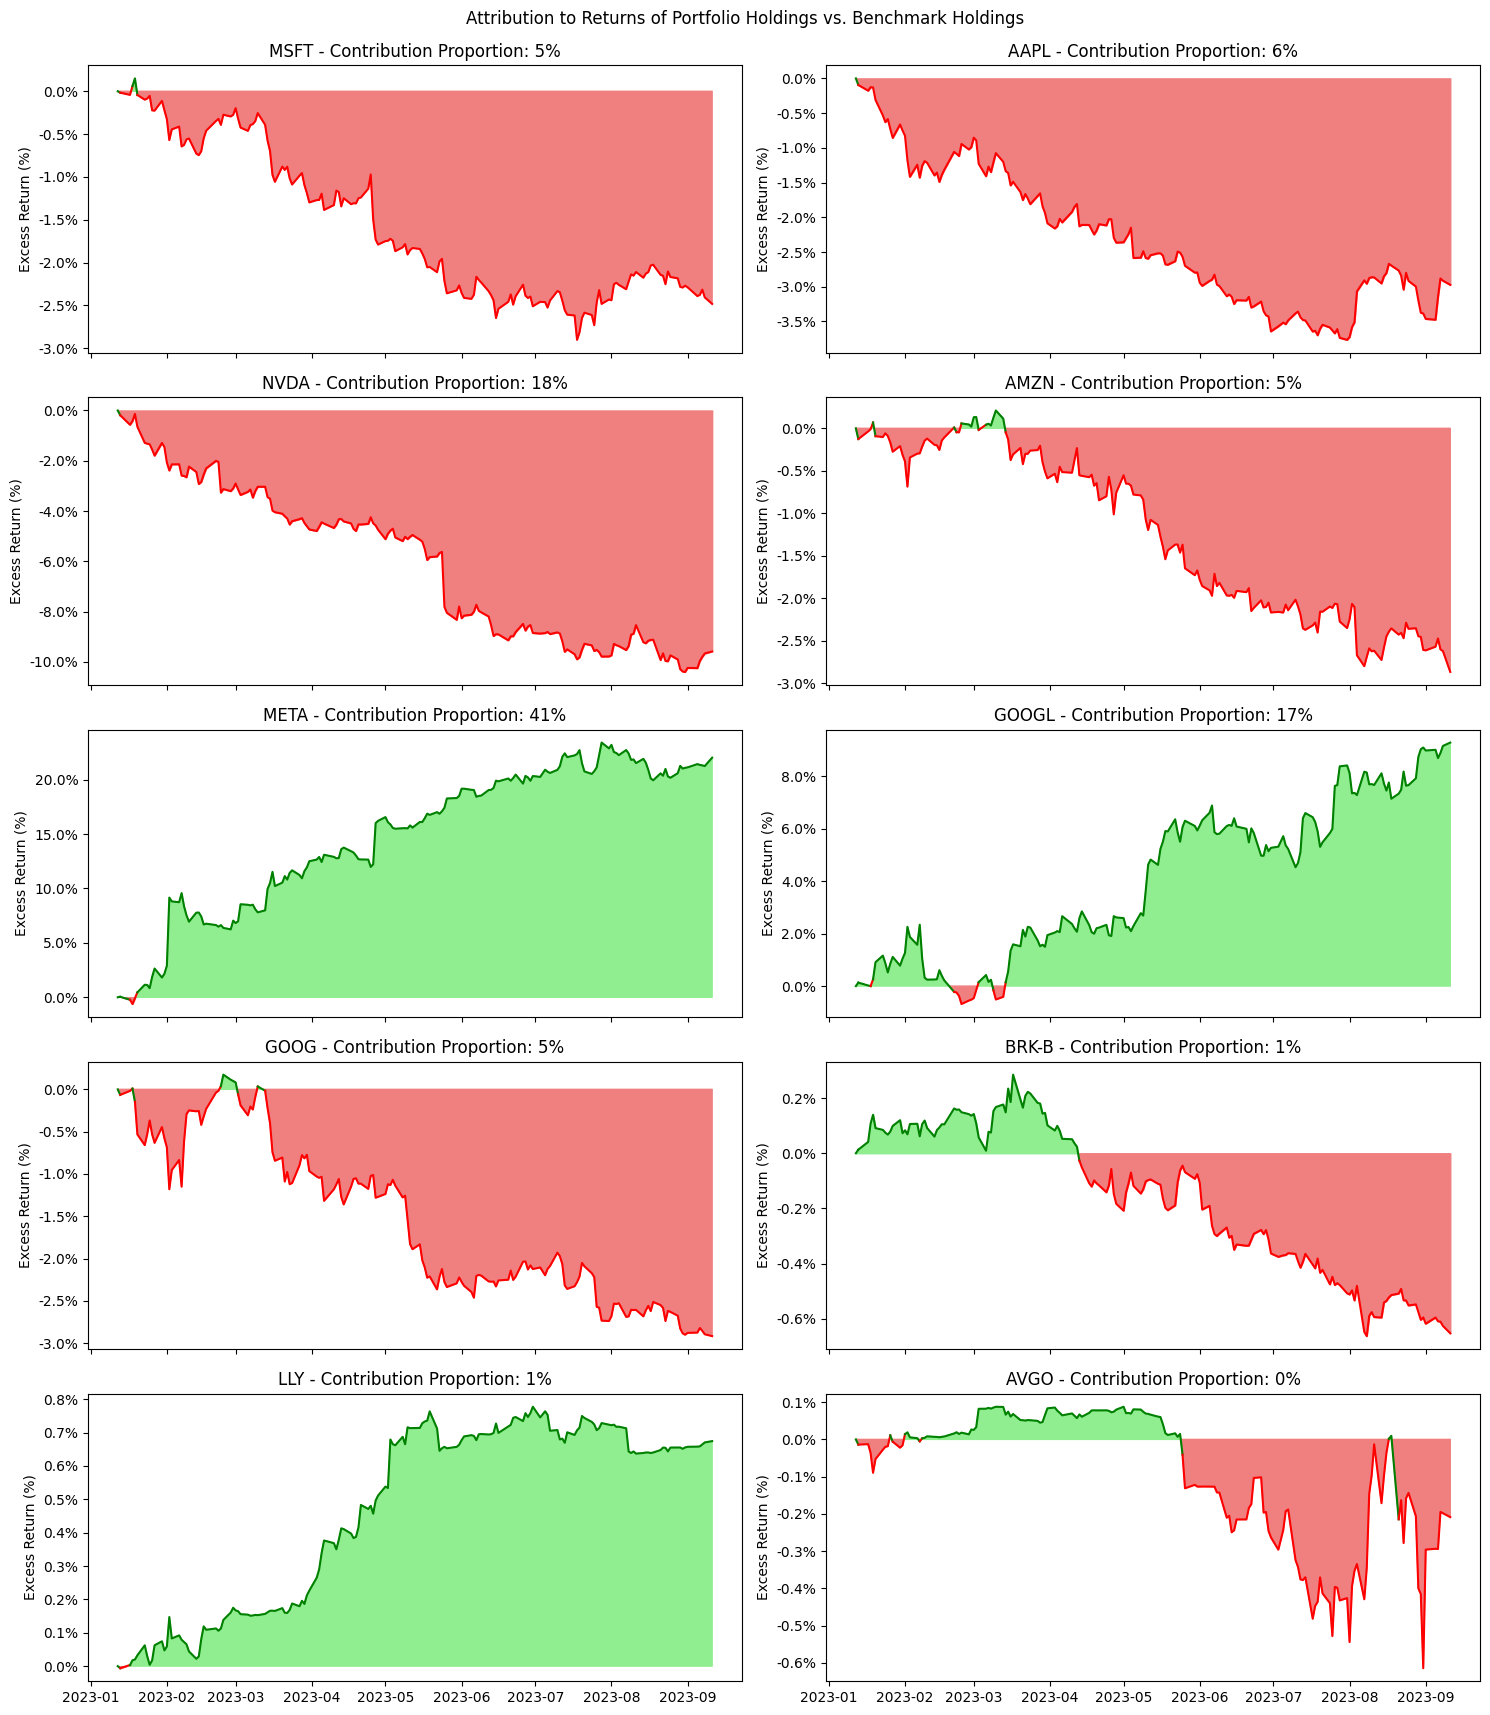

In [24]:
test_env.render(engine='matplotlib', plot_benchmark=True, plot_actions=True, plot_relative=True, plot_returns=True, plot_individual=True, plot_contribution=True)

##### Last Episode Performance

In [25]:
print('Agent Vol (Ann.): {:.3f}%'.format(np.std(test_env.portfolio_returns)*100*np.sqrt(252)))
print('Benchmark Vol (Ann.): {:.3f}%'.format(np.std(test_env.benchmark_returns)*100*(np.sqrt(252))))
print('Correlation: %.3f' % np.corrcoef(np.squeeze(test_env.portfolio_returns), np.squeeze(test_env.benchmark_returns))[0,1])
beta = np.cov(np.squeeze(test_env.portfolio_returns), np.squeeze(test_env.benchmark_returns), ddof=1)[0,1] / np.var(test_env.benchmark_returns, ddof=1)
print('Beta: %.3f' % beta)
print('Excess Return: {:.3f}%'.format((np.cumprod(1+test_env.portfolio_returns)[-1] - np.cumprod(1+test_env.benchmark_returns)[-1])*100))
print('Alpha (rf=0%): {:.3f}%'.format((np.cumprod(1+test_env.portfolio_returns)[-1] - beta*np.cumprod(1+test_env.benchmark_returns)[-1])*100))

Agent Vol (Ann.): 25.984%
Benchmark Vol (Ann.): 20.935%
Correlation: 0.930
Beta: 1.155
Excess Return: 11.361%
Alpha (rf=0%): -14.066%


##### Testing Sample Performance Statistics

In [26]:
interface.print_advanced_stats(test_history)

Avg. Reward: -0.003
Avg. Volatility (Agent, Ann.): 31.618%
Avg. Risk Utilization (% of benchmark): 124.898%
Avg. Beta: 1.144
Avg. Correlation: 0.920
Avg. Return (Epi.): 114.740%
Avg. Excess Return (Epi.): -1.124%
Avg. Alpha (Ann., rf=0%): -0.079%
